# Libraries

In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy import stats

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import *

# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Data Extraction

In [2]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

# Supervised Model Training

## Class for Model Selection

In [18]:
class ModelSelector:
    
    def __init__(self, *, model_class, labels_selected: list, data, param_grid_data, param_grid_model, kfold_splits):
        self.model_class = model_class
        self.labels_selected = labels_selected
        self.data = data
        self.param_grid_data = param_grid_data
        self.param_grid_model = param_grid_model
        self.kfold_splits = kfold_splits
        
    def extract_x_y(self):
        # Replace 'N' values with NaN
        data = replace_data(self.data)

        # Select the data for supervised learning (only rows where labels are not missing)
        data_copy = data.copy()
        data_with_label = data_copy[data_copy[self.labels_selected].notna().all(axis=1)]

        # Separate features and labels
        self.X, self.y = choose_labels(data_with_label, labels_chosen=self.labels_selected)
            
    def split(self, test_size=0.2, random_state=12):
        # Split data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)
        
    def apply_pipeline(self, X_train, X_test, y_train, y_test, params):
        # Apply the preprocessing pipeline with the provided parameters
        return pipeline_training_set(
            training_set=X_train, training_labels=y_train,
            testing_set=X_test, testing_labels=y_test, 
            labels_chosen=self.labels_selected,
            categorical_strategy=params['CategoricalStrategies'], 
            ordinal_strategy=params['OrdinalStrategies'], 
            is_PCA=params['is_PCA'], 
            pca_percent_explained_variance=params['pca_percent_explained_variance'],
            scaler_strategy=params['ScalerStrategy'], 
            pca_columns=params['PcaColumns'], 
            less_than_strategy=params['LessThanStrategy']
        )
        
    def cross_validation(self):
        # K-Fold cross-validation
        kfolds = KFold(n_splits=self.kfold_splits, shuffle=True, random_state=12)
        
        # Dictionary to store the average RMSE for each combination of hyperparameters
        results = {}

        # Generate all combinations of hyperparameters
        param_grid_total = self.param_grid_data | self.param_grid_model
        keys, values = zip(*param_grid_total.items())
        combinations = list(product(*values))

        # Iterate through each combination of hyperparameters
        for combo in combinations:
            params = dict(zip(keys, combo))
            
            rmse_list = []  # To store RMSE for each fold

            for fold, (train_index, val_index) in enumerate(kfolds.split(self.X_train, self.y_train)):
                model = self.model_class(**{k: v for k, v in params.items() if k in self.param_grid_model})
                
                X_sub_train = self.X_train.iloc[train_index, :]
                X_sub_val = self.X_train.iloc[val_index, :]
                y_sub_train = self.y_train.iloc[train_index]
                y_sub_val = self.y_train.iloc[val_index]

                # Apply the pipeline with the current parameters
                X_sub_train, X_sub_val, y_sub_train, y_sub_val = self.apply_pipeline(X_sub_train, X_sub_val, y_sub_train, y_sub_val, params)
                
                # Train and predict
                model.fit(X_sub_train, y_sub_train.to_numpy().ravel())
                y_sub_pred = model.predict(X_sub_val)
                
                # Calculate RMSE
                mse = mean_squared_error(y_sub_pred, y_sub_val)
                rmse = np.sqrt(mse)
                rmse_list.append(rmse)

            # Compute the average RMSE for this combination
            mean_rmse = np.mean(rmse_list)
            results[tuple(combo)] = mean_rmse

        # Find the best hyperparameter combination
        best_combo = min(results, key=results.get)
        self.best_rmse = results[best_combo]
        self.best_params = dict(zip(keys, best_combo))

        print("Best hyperparameters with cross-validation: {}".format(self.best_params))
        print("Best Mean RMSE on cross-validation: {:.3}".format(self.best_rmse))
    
    def score(self):
        # Apply the pipeline with the best hyperparameters
        X_train, X_test, y_train, y_test = self.apply_pipeline(self.X_train, self.X_test, self.y_train, self.y_test, self.best_params)
        
        # Train the model with the best parameters
        model = self.model_class(**{k: v for k, v in self.best_params.items() if k in self.param_grid_model})
        model.fit(X_train, y_train.to_numpy().ravel())
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        # Calculate training and test RMSE
        train_mse = mean_squared_error(y_train_pred, y_train)
        train_rmse = np.sqrt(train_mse)
        test_mse = mean_squared_error(y_pred, y_test)
        test_rmse = np.sqrt(test_mse)
        
        # Calculate R-squared score
        r2 = r2_score(y_test, y_pred)
        
        # Output results
        print("Final RMSE on train set: {:.3}".format(train_rmse))
        print("Final RMSE on test set: {:.3}".format(test_rmse))
        print("Final R2 on test set: {:.3}".format(r2))
        
        return y_pred, y_test
        
    def plot(self, y_pred, y_test):
        # Plot predicted vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, y_test, color='blue', label='Predicted vs Actual')
        plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2, label='Ideal Fit')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Actual vs Predicted')
        plt.legend()
        plt.show()


## Simple Linear Regression

In [ ]:
# Selection of the data hyper parameters on a simple model in order to store then for more complex models

model_class = LinearRegression
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [True],
        'pca_percent_explained_variance' : [0.5],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }

param_grid_linear = {}

kfold_splits = 5

model = ModelSelector(model_class= model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_linear, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

"""
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean'}
Best Mean RMSE on cross-validation : 78.1
Final RMSE on test set : 77.2
"""

## XGboost

Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.5, 'PcaColumns': 'concentration', 'LessThanStrategy': 'mean', 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 0.3, 'subsample': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0}
Best Mean RMSE on cross-validation: 40.3
Final RMSE on train set: 15.6
Final RMSE on test set: 34.6
Final R2 on test set: 0.871


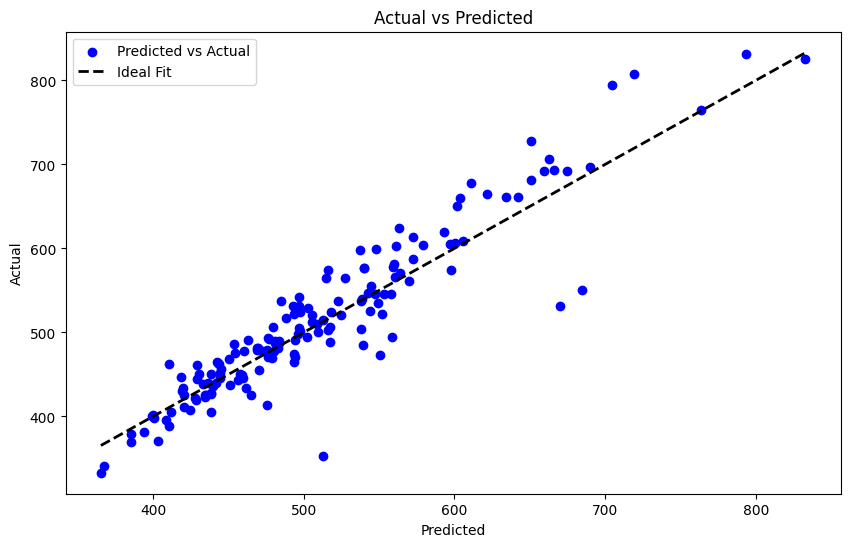

"\nBest hyperparameters with cross-validation : {'OrdinalStrategies': 'linear', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.7, 'PcaColumns': 'concentration', 'LessThanStrategy': 'max', 'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'gamma': 0.3, 'subsample': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0}\nBest Mean RMSE on cross-validation : 48.9\nFinal RMSE on test set : 44.6\nFinal r2 on test set : 0.779\n"

In [21]:
model_class = xgb.XGBRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [False],
        'pca_percent_explained_variance' : [0.5],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }

param_grid_xgboost = {
    'n_estimators': [200],     
    'learning_rate': [0.1],  
    'max_depth': [3],         
    'gamma': [0.3],          
    'subsample': [0.8],       
    'reg_alpha': [0.1],           
    'reg_lambda': [0],           
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_xgboost, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)

"""
Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.5, 'PcaColumns': 'concentration', 'LessThanStrategy': 'mean', 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 0.3, 'subsample': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0}
Best Mean RMSE on cross-validation: 40.3
Final RMSE on train set: 15.6
Final RMSE on test set: 34.6
Final R2 on test set: 0.871
"""

## GBR

Best hyperparameters with cross-validation: {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.5, 'PcaColumns': 'concentration', 'LessThanStrategy': 'mean', 'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 5}
Best Mean RMSE on cross-validation: 38.6
Final RMSE on train set: 4.05
Final RMSE on test set: 32.9
Final R2 on test set: 0.883


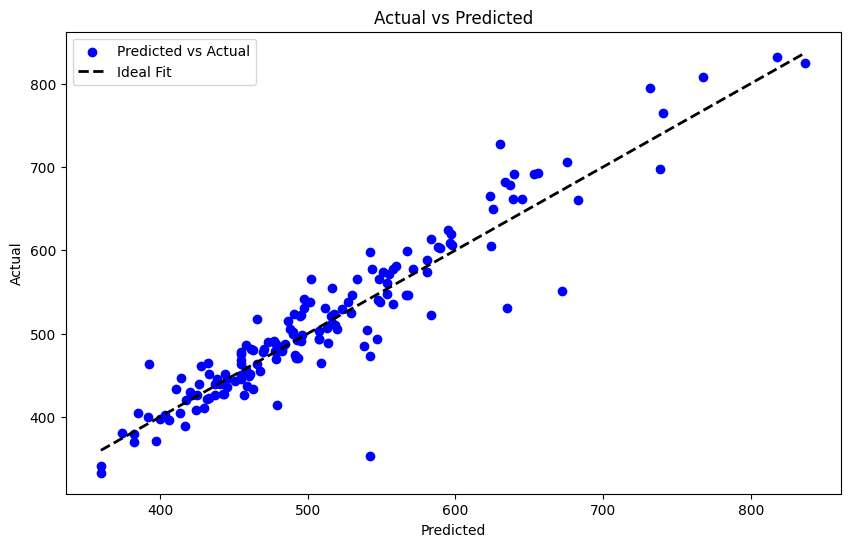

"\nBest hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}\nBest Mean RMSE on cross-validation : 40.6\nFinal RMSE on train set : 8.47\nFinal RMSE on test set : 31.9\nFinal r2 on test set : 0.891\n\n"

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

model_class = GradientBoostingRegressor
labels_selected = ["Yield_strength"]

# Testing param grid data : 
# param_grid_data = {
#         'OrdinalStrategies': ["mean", "linear"],
#         'CategoricalStrategies': ["most_frequent", "logistic"],
#         'ScalerStrategy': ["standard", "normalizer"],
#         'is_PCA': [True, False],
#         'pca_percent_explained_variance' : [0.5, 0.6, 0.7, 0.8, 0.9],
#         'PcaColumns': ['concentration', 'all_ordinals'],
#         'LessThanStrategy': ['max', 'mean']
#     }

# Final param grid data : 
param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [False],
        'pca_percent_explained_variance' : [0.5],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }


# Testing param grid model : 
# param_grid_gbr = {
#     'n_estimators': [200, 300, 400],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
# }

# Final param grid model : 
param_grid_gbr = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [5],
}


kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_gbr, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)

"""
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}
Best Mean RMSE on cross-validation : 40.6
Final RMSE on train set : 8.47
Final RMSE on test set : 31.9
Final r2 on test set : 0.891

"""

## Random Forest

Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.5, 'PcaColumns': 'concentration', 'LessThanStrategy': 'mean', 'n_estimators': 500, 'max_depth': 10, 'bootstrap': True}
Best Mean RMSE on cross-validation : 46.1
Final RMSE on train set : 23.4
Final RMSE on test set : 43.7
Final r2 on test set : 0.795


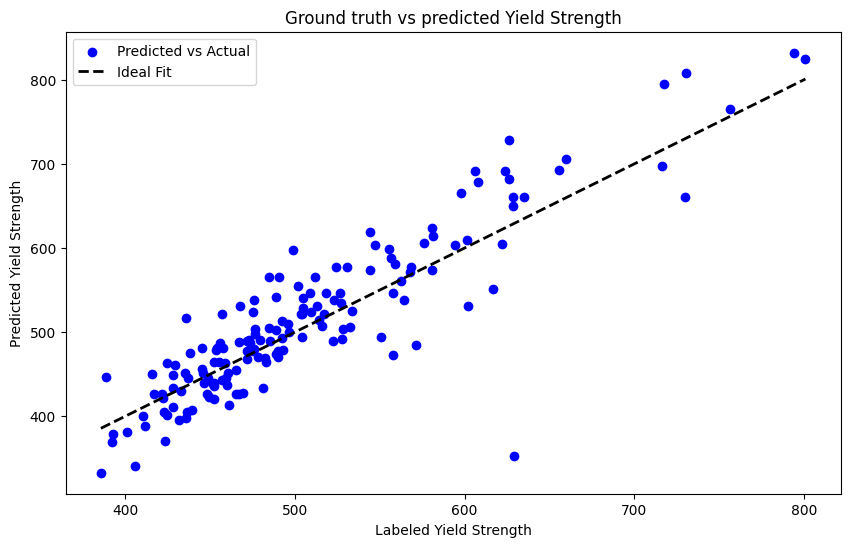

In [9]:
model_class = RandomForestRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [False],
        'pca_percent_explained_variance' : [0.5],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }

param_grid_rf = {
    'n_estimators': [500],             
    'max_depth': [10],               
    'bootstrap': [True]                     
}


kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_rf, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)

## LGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 499, number of used features: 29
[LightGBM] [Info] Start training from score 509.217635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

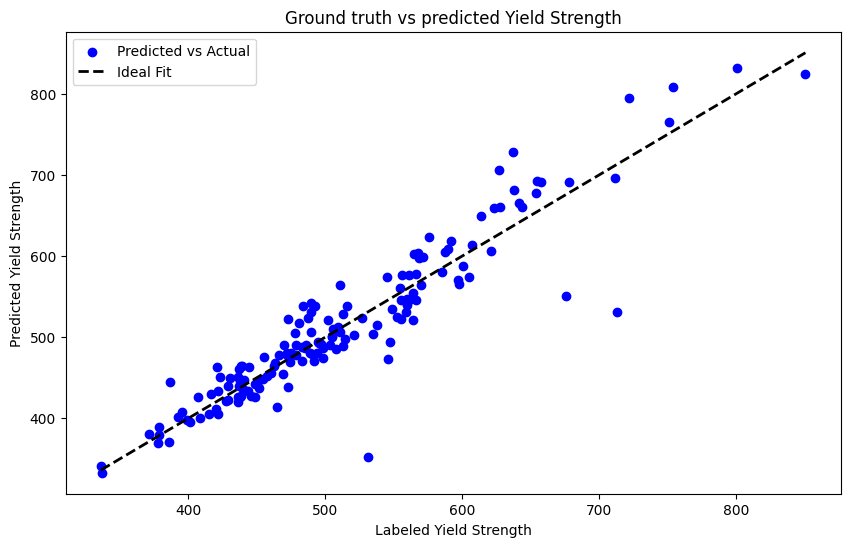

In [13]:
model_class = lgb.LGBMRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [False],
        'pca_percent_explained_variance' : [0.5],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }

param_grid_lgbm = {
    'n_estimators': [500],
    'learning_rate': [0.1],
    'max_depth': [3],
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_lgbm, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)


## KNN

Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'is_PCA': False, 'pca_percent_explained_variance': 0.7, 'PcaColumns': 'concentration', 'LessThanStrategy': 'mean', 'n_neighbors': 4}
Best Mean RMSE on cross-validation : 63.6
Final RMSE on train set : 41.2
Final RMSE on test set : 56.0
Final r2 on test set : 0.662
Final RMSE on train set : 43.1
Final RMSE on test set : 55.5
Final r2 on test set : 0.668


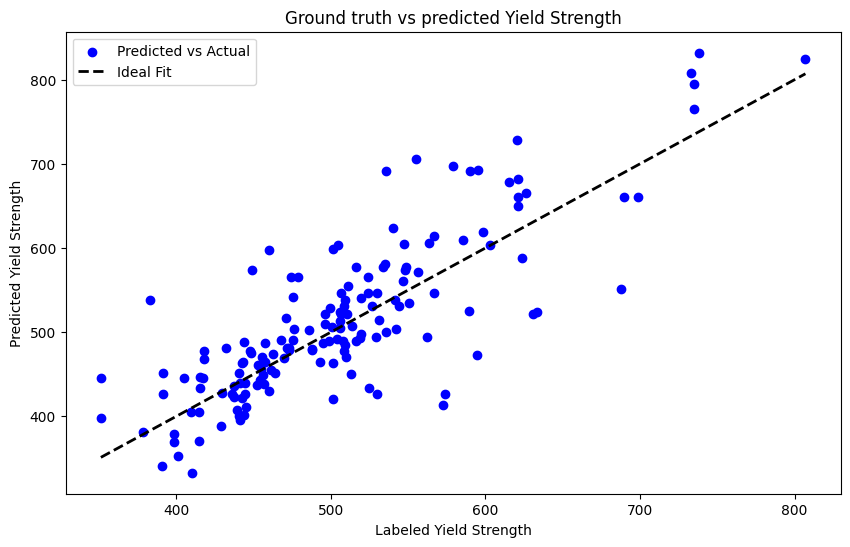

In [16]:
from sklearn.neighbors import KNeighborsRegressor

model_class = KNeighborsRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean"],
        'CategoricalStrategies': ["most_frequent"],
        'ScalerStrategy': ["standard"],
        'is_PCA': [False],
        'pca_percent_explained_variance' : [0.7],
        'PcaColumns': ['concentration'],
        'LessThanStrategy': ['mean']
    }

param_grid_KNN = {
    'n_neighbors': [4]
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_KNN, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()
y_pred, y_test = model.score()
model.plot(y_pred, y_test)

# Semi-Supervised Model Training

## Self Training

In [22]:
class ModelSelectorSemiSupervised:

    def __init__(self, *, model_class, labels_selected: list, data, param_grid_data, param_grid_model, confidence_threshold):
        self.model_class = model_class
        self.labels_selected = labels_selected
        self.data = data
        self.param_grid_data = param_grid_data
        self.param_grid_model = param_grid_model
        self.confidence_threshold = confidence_threshold

    def extract_x_y(self):
        # Replace 'N' value with NaN
        data = replace_data(self.data)

        # Select data for supervised learning
        data_copy = data.copy()
        data_with_label = data_copy[data_copy[self.labels_selected].notna().all(axis=1)]
        data_without_label = data_copy[data_copy[self.labels_selected].isna().all(axis=1)]

        # Separate features and labels
        self.X_with_label, self.y_with_label = choose_labels(data_with_label, labels_chosen=self.labels_selected)
        self.X_without_label, self.y_without_label = choose_labels(data_without_label, labels_chosen=self.labels_selected)

    def split(self, test_size=0.2, random_state=42):
        self.X_train_with_label, self.X_test_with_label, self.y_train_with_label, self.y_test_with_label = train_test_split(
            self.X_with_label, self.y_with_label, test_size=test_size, shuffle=True, random_state=random_state)

    def apply_pipeline(self, X_train, X_test, y_train, y_test):
        # Apply data processing pipeline
        return pipeline_training_set(
            training_set=X_train, training_labels=y_train,
            testing_set=X_test, testing_labels=y_test,
            labels_chosen=self.labels_selected,
            categorical_strategy=self.param_grid_data['CategoricalStrategies'],
            ordinal_strategy=self.param_grid_data['OrdinalStrategies'],
            is_PCA=self.param_grid_data['is_PCA'],
            pca_percent_explained_variance=self.param_grid_data['pca_percent_explained_variance'],
            scaler_strategy=self.param_grid_data['ScalerStrategy'],
            pca_columns=self.param_grid_data['PcaColumns'],
            less_than_strategy=self.param_grid_data['LessThanStrategy']
        )

    def get_prediction_interval(self, X, y_pred, percentile=95):
        """
        Calculate the prediction interval using a bootstrap approach
        """
        if isinstance(self.base_model, GradientBoostingRegressor):
            # For GradientBoostingRegressor, use variance of predictions
            std = np.zeros_like(y_pred)
            for pred in self.base_model.staged_predict(X):
                std += (pred - y_pred) ** 2
            std = np.sqrt(std / len(self.base_model.estimators_))

            interval = stats.norm.ppf(1 - (1 - percentile / 100) / 2) * std
            lower = y_pred - interval
            upper = y_pred + interval
            return lower, upper
        else:
            # For other models, use simple bootstrap approach
            raise ValueError("Unsupported model type. Only GradientBoostingRegressor is currently supported for prediction intervals.")

    def fit_predict_base_model(self):
        # Apply pipeline
        X_train_with_label, X_without_label, y_train_with_label, y_without_label = self.apply_pipeline(
            self.X_train_with_label, self.X_without_label, self.y_train_with_label, self.y_without_label)

        # Train the base model
        model = self.model_class(**self.param_grid_model)
        model.fit(X_train_with_label, y_train_with_label.to_numpy().ravel())
        self.base_model = model

        # Make predictions on unlabeled data
        self.y_pred_without_label = model.predict(X_without_label)

        # Calculate prediction intervals
        lower, upper = self.get_prediction_interval(X_without_label, self.y_pred_without_label)

        # Select confident predictions based on interval width
        interval_width = upper - lower
        median_width = np.median(interval_width)
        confident_mask = interval_width <= (median_width * self.confidence_threshold)

        self.confident_mask = confident_mask

        print(f"Number of retained predictions: {confident_mask.sum()} out of {len(confident_mask)}")
        print(f"Percentage of retained data: {100 * confident_mask.sum() / len(confident_mask):.2f}%")

    def fit_global_model(self):
        # Use only confident predictions

        X_confident = self.X_without_label[self.confident_mask]
        y_confident = self.y_pred_without_label[self.confident_mask]

        # Combine labeled data and confident predictions
        X_train = pd.concat([self.X_train_with_label, X_confident], axis=0)
        y_train = pd.concat([self.y_train_with_label, pd.DataFrame(y_confident, columns=[self.y_train_with_label.columns[0]])], axis=0)

        # Apply pipeline and train the final model
        X_train, X_test, y_train, y_test = self.apply_pipeline(X_train, self.X_test_with_label, y_train, self.y_test_with_label)

        final_model = self.model_class(**self.param_grid_model)
        final_model.fit(X_train, y_train.to_numpy().ravel())

        y_pred = final_model.predict(X_test)
        y_train_pred = final_model.predict(X_train)
        train_mse = mean_squared_error(y_train_pred, y_train)
        train_rmse = np.sqrt(train_mse)
        test_mse = mean_squared_error(y_pred, y_test)
        test_rmse = np.sqrt(test_mse)
        r2 = r2_score(y_test, y_pred)

        print(f"Final RMSE on train set: {train_rmse:.3}")
        print(f"Final RMSE on test set: {test_rmse:.3}")
        print(f"Final R2 on test set: {r2:.3}")


In [27]:
model_class = GradientBoostingRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': "mean",
        'CategoricalStrategies': "most_frequent",
        'ScalerStrategy': "standard",
        'is_PCA' : False,
        'pca_percent_explained_variance' : 0.7,
        'PcaColumns': 'concentration',
        'LessThanStrategy': 'mean'
    }


param_grid_gbr = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 5,
}

# 
confidence_threshold = 0

for i in range(10):

    print("============== Confidence = {} ==============". format(confidence_threshold))
    

    model = ModelSelectorSemiSupervised(model_class= model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_gbr, confidence_threshold=confidence_threshold)

    model.extract_x_y()
    model.split()
    model.fit_predict_base_model()
    model.fit_global_model()
    
    confidence_threshold+=0.2


============== Confidence = 0 ==============
Number of retained predictions: 0 out of 872
Percentage of retained data: 0.00%
Final RMSE on train set: 4.08
Final RMSE on test set: 31.3
Final R2 on test set: 0.891
============== Confidence = 0.2 ==============
Number of retained predictions: 10 out of 872
Percentage of retained data: 1.15%
Final RMSE on train set: 3.7
Final RMSE on test set: 32.1
Final R2 on test set: 0.886
============== Confidence = 0.4 ==============
Number of retained predictions: 122 out of 872
Percentage of retained data: 13.99%
Final RMSE on train set: 4.06
Final RMSE on test set: 32.5
Final R2 on test set: 0.883
============== Confidence = 0.6000000000000001 ==============
Number of retained predictions: 224 out of 872
Percentage of retained data: 25.69%
Final RMSE on train set: 4.23
Final RMSE on test set: 33.8
Final R2 on test set: 0.874
============== Confidence = 0.8 ==============
Number of retained predictions: 354 out of 872
Percentage of retained data: 40